# Métodos no supervisados: Topic Modeling y Clustering
Cuándo se está trabajando con un dataset compuesto de una gran cantidad de documentos se quiere saber cuál es el tema del que tratan. Es muy complicado asignar un único tema al corpus debido a qué está compuesto por textos con gran variedad de temas, más en este caso en el que se trabaja con un dataset conformado por comentarios de usuarios. 

Es en este punto cuando entra en juego el Topic Modeling (Modelado de temas). Este tipo de modelado se utiliza para determinar la estructura global del corpus mediante diversas técnicas estadísticas, no para asignar un tema concreto a cada uno de los documentos del corpus.

En este apartado se estudiarán varios métodos para el modelado de temas que permitirán entender su funcionamiento y cómo pueden ser utilizados para generar resúmenes de los documentos de forma rápida.

Para esta tarea se utilizará el dataset conformado por los comentarios de usuarios del repositorio "Zigbee2mqtt" que ya ha sido utilizado en tareas anteriores, lo que permite agilizar el proceso de modelado de temas porque este ya está tokenizado, vectorizado, etc.

Al igual que en todos los apartados, se comienza importando los ajustes del proyecto junto con la base de datos en la que se encuentra almacenado el Data Frame.

In [1]:
import sys, os

#Carga del archivo setup.py
%run -i ../pyenv_settings/setup.py

#Imports y configuraciones de gráficas
%run "$BASE_DIR/pyenv_settings/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# # to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# # otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

You are working on a local system.
Files will be searched relative to "..".


In [2]:
#Conexión con la base de datos en la que tenemos guardado el Data Frame
db_name = "../data/zigbee2mqtt_comments.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from comments", con)
con.close()

#Comprobación de que se ha cargado correctamente
print(df.columns)
print(df[['normalized_text', 'tokens']].head(4))

Index(['id', 'user', 'text', 'impurity', 'clean_text', 'normalized_text',
       'tokens'],
      dtype='object')
                                                                                                                                                                                           normalized_text  \
0                                                                    This issue is stale because it has been open 30 days with no activity. Remove stale label or comment or this will be closed in 7 days   
1  Also, after updating the z2m, cyclic reboots began ''' Starting Zigbee2MQTT without watchdog. INFO: Preparing to start... INFO: Socat not enabled INFO: Starting Zigbee2MQTT... Starting Zigbee2MQTT...   
2  Hi ! Since 2 or 3 days, MQTT suddenly fail. A few messages in the log, many auto restart, and works again ... Very strange. In the log INFO: Preparing to start... ERROR: Got unexpected response fr...   
3  I don't know if it's exactly the same, but since v1.42 I ha

**Recordar que en la columna "normalized_text" se encuentran todos los comentarios ya normalizados y vectorizados, es decir, con todos los pasos que se han seguido para obtener un texto limpio y listo para utilizarse en tareas de modelado**

## Pasos previos
Antes de comenzar el modelado, es recomendable conocer la información del corpues para así determinar cuáles son las entidades que se analizarán.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2678 entries, 0 to 2677
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2678 non-null   int64  
 1   user             2678 non-null   object 
 2   text             2678 non-null   object 
 3   impurity         2678 non-null   float64
 4   clean_text       2678 non-null   object 
 5   normalized_text  2678 non-null   object 
 6   tokens           2678 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 146.6+ KB


A priori parece una buena base para el modelado teniendo en cuenta que no hay elemenos nulos en ninguna columna. De todos modos, se puede imprimir por pantalla alguna muestra de estos tectos para comprobar si estos contienen caracteres especiales como puede ser la tabulación (\t), nueva línea (\r), retorno de carro (\r), etc.

In [4]:
print(repr(df.iloc[0]["normalized_text"][0:200]))
print(repr(df.iloc[-1]["normalized_text"][0:200]))

'This issue is stale because it has been open 30 days with no activity. Remove stale label or comment or this will be closed in 7 days'
"Is thist error? I have (old config) ''' socat: restartdelay: 1 initialdelay: 1 ''' in config but when i check default config this positions will disaapear."


Como el data frame ya había sido procesado y limpiado previamente, no se encuentran caracteres especiales que puedan dificultar el modelado.

Una vez completado este paso, se pasaría a la vectorización de los datos. En este caso, los datos ya fueron vectorizados anteriormente en *e_featureEngineering_and_syntactSimilarity.ipynb* de este mismo proyecto, permitiendo ahorrar tiempo y agilizar el proceso para cumplir el objetivo de este apartado.

## Factorización de matrices no negativas (NMF) con scikit-learn
Conceptualmente, la forma más sencilla de hallar la estructura implícita en el corpus es la factorización de la matriz de términos, pero puede presentar un gasto computacional muy elevado. 

En lugar de esto, se puede realizar una factorización aproximada que es menos costoso y al mismo tiempo arroja buenos resultados.

Algunos métodos de álgebra lineal permiten representar la matriz como el producto de otras dos matrices no negativas. En este caso se nombrará la matriz original como *V*, y los factores *W* y *H*. 

### Creación de Modelos temáticos utilizando NMF
Casi todos los modelados de temas necesitan un número de temas como parámetro de entrada. En lugar de utilizar todos los temas de todos los textos, se utilizará un número aleatorio para esta tarea, por ejemplo 10. Este número es variable en cualquier caso, al fin y al cabo lo que se busca es un resultado más afinado, pero tampoco puede ser un número demasiado elevado de forma que el gasto computacional exceda los valores deseados.

Como la vectorización de los textos fue llevada a cabo en otro documento del proyecto, en este se deberá realizar el proceso otra vez para poder hacer uso de la variable que almacena los vectores.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['normalized_text'])
tfidf_text_vectors.shape

(2678, 1721)

In [6]:
# Comprobación de que no se pierde información
df['normalized_text'].info()
print(df['normalized_text'].sample(5))

<class 'pandas.core.series.Series'>
RangeIndex: 2678 entries, 0 to 2677
Series name: normalized_text
Non-Null Count  Dtype 
--------------  ----- 
2678 non-null   object
dtypes: object(1)
memory usage: 21.0+ KB
2377               Success! Basically the above steps are what I followed. One thing I noticed is that uninstalling the old add-on does not remove the /share/zigbee2mqtt folder but just in case, make a copy!
806                                                                                                                          _URL_ known about, will be in September release I understand from various threads.
2246    Your serial port is not accessible, or it changed (Error: Error while opening serialport 'Error: Error: No such file or directory, cannot open /dev/ttyACM0'). Check your hardware in System tab for...
1572                                                                                                                                                                 

In [7]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

El tema de un texto viene dado por la distribución de las palabras que contiene, por lo tanto, analizar esta distribución puede ser de gran ayuda para descubrir los temas.

Haciendo uso de la matriz H, se debe encontrar el índice de los mayores valores de cada fila para luego ser utilizado como índice de búsqueda en el vocabulario.

Se definirá una función que evalúe el modelo y muestre por pantalla un resumen de los temas (topics) que NMF ha detectado en los textos.

In [8]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [9]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  stale (18.06)
  days (17.31)
  activity (8.96)
  label (8.96)
  comment (8.86)

Topic 01
  add (2.32)
  z2m (2.01)
  version (1.86)
  ha (1.43)
  new (1.23)

Topic 02
  thanks (50.82)
  worked (3.38)
  working (1.87)
  lot (1.09)
  reply (0.99)

Topic 03
  issue (41.26)
  having (2.15)
  got (1.62)
  close (1.11)
  exact (1.07)

Topic 04
  _url_ (29.25)
  duplicate (4.55)
  related (2.59)
  closing (1.28)
  device (1.22)

Topic 05
  error (3.03)
  zigbee (2.55)
  zigbee2mqtt (2.52)
  herdsman (2.11)
  info (2.04)

Topic 06
  problem (21.86)
  solution (3.05)
  solved (2.78)
  zha (1.10)
  thank (1.09)

Topic 07
  config (4.15)
  zigbee2mqtt (2.28)
  configuration (2.24)
  yaml (2.03)
  addon (1.85)

Topic 08
  fixed (16.32)
  edge (5.29)
  dev (4.58)
  branch (4.31)
  latest (3.39)

Topic 09
  update (13.43)
  42 (3.94)
  working (1.91)
  version (1.40)
  updated (1.36)


La salida muestra las palabras más relevantes para cada tema, permitiendo determinar la temática de algunos de los comentarios. Por ejemplo, en *Topic 02* se puede deducir que se trata de un mensaje de agradeciemiento como respuesta a otro y en *Topic 04* que se trata de algún problema con una URL concreta.

Sería interesante conocer como de grande es una temática, es decir, cuantos comentarios están relacionados con un mismo tema por ejemplo. 

Esto se puede calcular utilizando la matriz de temas de un documento y sumando las contribuciones individuales a este a lo largo de todos los documentos del data frame.

In [10]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([18.15077823, 11.61180167,  5.36082748,  9.99092406,  8.43365604,
       10.84861004,  7.45875981, 12.96782206,  6.9400853 ,  8.23673532])

Este resultado indica que hay temas de mayor y menor peso pero no hay grandes diferencias en los porcentajes, indicando una supuesta buena calidad al tener una distribución bastante similar.

### Creación de Modelos temáticos utilizando SVD
Otro algoritmo utilizado para el modelo de temas es el basado en la *descomposición de valores singular (SVD)* 

Se trata de una técnica de factorización matricial utilizada para reducir la dimensionalidad de los datos y extraer patrones semánticos latentes. En este método, la matriz de datos es descompuesta en tres matrices: *U*, que representa la relación entre documentos y conceptos latentes; *Σ*, que contiene los valores singulares que indican la importancia de cada concepto; y *V^T*, que relaciona términos con estos conceptos.

En el procesamiento de lenguaje natural habitualmente se utiliza una variante de este algoritmo denominada *Truncated SVD* que reduce considerablemente el costo computacional.

In [11]:
from sklearn.decomposition import TruncatedSVD

svd_text_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix = svd_text_model.components_

La función antes definida para evaluar y mostrar por pantalla el modelo puede ser reutilizado para este método.

In [12]:
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  stale (15.99)
  days (15.34)
  activity (7.94)
  label (7.94)
  comment (7.85)

Topic 01
  zigbee2mqtt (1.53)
  issue (1.20)
  _url_ (1.04)
  config (0.94)
  error (0.88)

Topic 02
  thanks (52.50)
  issue (8.42)
  _url_ (6.00)
  worked (3.65)
  working (2.58)

Topic 03
  issue (17.00)
  _url_ (13.62)
  duplicate (2.07)
  fixed (2.04)
  related (1.32)

Topic 04
  _url_ (65.02)
  duplicate (10.46)
  stale (6.17)
  days (5.29)
  related (5.24)

Topic 05
  _url_ (8.70)
  issue (7.85)
  error (7.07)
  herdsman (6.39)
  zigbee (6.35)

Topic 06
  problem (1525.35)
  solution (208.44)
  solved (189.74)
  version (145.35)
  zigbee (143.70)

Topic 07
  update (50.30)
  version (49.80)
  edge (36.24)
  latest (18.68)
  fixed (15.63)

Topic 08
  fixed (119.10)
  dev (55.34)
  edge (51.06)
  branch (39.53)
  z2m (32.51)

Topic 09
  addon (6.22)
  zigbee2mqtt (5.33)
  fixed (4.58)
  update (4.50)
  config (3.81)


In [13]:
svd_text_model.singular_values_

array([18.83292308,  8.18662956,  6.33037565,  6.15879161,  5.60076025,
        5.34577855,  4.83188556,  4.51548091,  4.19867845,  4.0088322 ])

Al igual que con NMF, los valores singulares obtenidos representan la importancia relativa de cada componente latente en la estructura del texto. Un valor más alto indica que el componente correspondiente explica una mayor variabilidad en los datos, lo que sugiere que los temas asociados a esos componentes son más representativos en el corpus. A medida que los valores disminuyen, los temas capturados tienen menor influencia en la distribución global de términos y documentos. Esto permite reducir la dimensionalidad del texto, reteniendo solo las estructuras más significativas para el análisis.

Ambos métodos vistos utilizan métodos algebraicos usando como base la matriz de términos para la descomposición de temas. A partir de este punto, se verán modelos probabilísticos cuya popularidad ha aumentado en los últimos años.

## Asignación latente de Dirichlet (LDA) con scikit-learn
LDA es el método de modelado de tópicos más popular en los últimos tiempos gracias a su capacidad de adaptación en diferentes escenarios.

Su funcionamiento consiste en leer cada documento como una mezcla de diferentes temas que a su vez son una mezcla de palabras. Para mantener una cantidad reducida de estos hace uso de la distribución Dirichlet que asegura que cada documento esté compuesto por unos pocos tópicos que al mismo tiempo están compuestos por una cantidad reducida de palabras.

### Creación de Modelos temáticos utilizando LDA
Para este tipo de modelos también se utilizará la librería *scikit-learn*. Debido a que se hace uso de un método probabilístico, la duración del proceso es mayor en comparación con NMF y SVD.

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df['normalized_text'])
count_text_vectors.shape

(2678, 1721)

In [15]:
from sklearn.decomposition import LatentDirichletAllocation

lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

En este caso también se puede utilizar la función antes definida para la evaluación y muestra de los resultados:

In [16]:
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  add (2.30)
  version (1.94)
  zigbee2mqtt (1.93)
  addon (1.74)
  issue (1.71)

Topic 01
  false (4.80)
  null (3.89)
  failed (2.97)
  zigbee2mqtt (2.81)
  state (2.71)

Topic 02
  ezsp (5.00)
  zigbee (4.44)
  01 (4.30)
  adapter (3.80)
  herdsman (3.63)

Topic 03
  days (13.49)
  stale (12.90)
  issue (7.89)
  open (7.75)
  remove (7.53)

Topic 04
  zigbee (4.76)
  herdsman (4.03)
  zigbee2mqtt (3.47)
  error (3.40)
  adapter (2.97)

Topic 05
  config (3.35)
  mqtt (2.77)
  file (2.59)
  port (2.54)
  zigbee2mqtt (2.30)

Topic 06
  info (5.37)
  root (3.65)
  zigbee2mqtt (3.59)
  22 (2.16)
  11 (1.39)

Topic 07
  z2m (2.32)
  _url_ (2.00)
  problem (1.93)
  issue (1.72)
  device (1.36)

Topic 08
  2022 (7.85)
  08 (6.97)
  10 (5.63)
  zigbee2mqtt (5.55)
  30 (5.29)

Topic 09
  mainthread (7.16)
  10 (6.33)
  zigbee2mqtt (4.70)
  option (4.37)
  warning (4.32)


In [17]:
W_lda_text_matrix.sum(axis=0)/W_lda_text_matrix.sum()*100.0

array([32.30908695,  3.43165214,  3.47439399, 16.02876733,  5.04281378,
        6.09383153,  5.47115736, 22.13451431,  2.4828182 ,  3.53096439])

A simple vista se aprecia que LDA ha generado una estructura de temas bastante diferente en comparación con las anteriores. Además, en los resultados hay un porcentaje que destaca por ser muy grande en comparación con los demás, indicando así que la calidad del modelo puede mejorarse pues la distribución no es muy equivalente. Esto se podría conseguir variando el número de documentos elegidos para la ejecución hasta conseguir una distribución con menos diferencia entre los resultados que se obtengan.

#### Visualización de los resultados de LDA
La librería pyLDAvis es útil para la visualización de los resultados del modelado LDA tomando directamente los resultados obtenidos previamente.

In [18]:
import pyLDAvis
import pyLDAvis.lda_model

lda_display = pyLDAvis.lda_model.prepare(
    lda_text_model,  # Modelo LDA entrenado
    count_text_vectors,  # Matriz documento-término
    count_text_vectorizer,  # Vectorizador (para obtener vocabulario)
    sort_topics=False
)

pyLDAvis.display(lda_display)

In [19]:
lda_tsne_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

La visualización generada por pyLDAvis ofrece una representación gráfica de los temas extraídos de un conjunto de documentos. En ella, cada tema se representa como un círculo cuyo tamaño indica su prominencia en el conjunto de datos, mientras que la posición refleja su relación con otros temas. Las palabras más frecuentes y representativas de cada tema se muestran junto al círculo correspondiente, lo que permite interpretar el contenido de los temas. Esta visualización facilita la comprensión de las principales categorías presentes en los textos, ayuda a identificar patrones y relaciones entre los temas, y es útil para asignar documentos a sus temas más relevantes o explorar soluciones a problemas comunes en grandes volúmenes de texto.

### Utilización de nubes de palabras para mostrar y comparar modelos
En capítulos anteriores ya se han visto y explicado lo útiles que pueden ser las nubes de palabras para comparar las diferencias entre los resultados de unos y otros modelos.

Se generarán ahora estas nubes para ver las que hay entre los modelos NMF y LDA.

In [20]:
#%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        #plt.savefig(f'topic{topic}.png')

/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


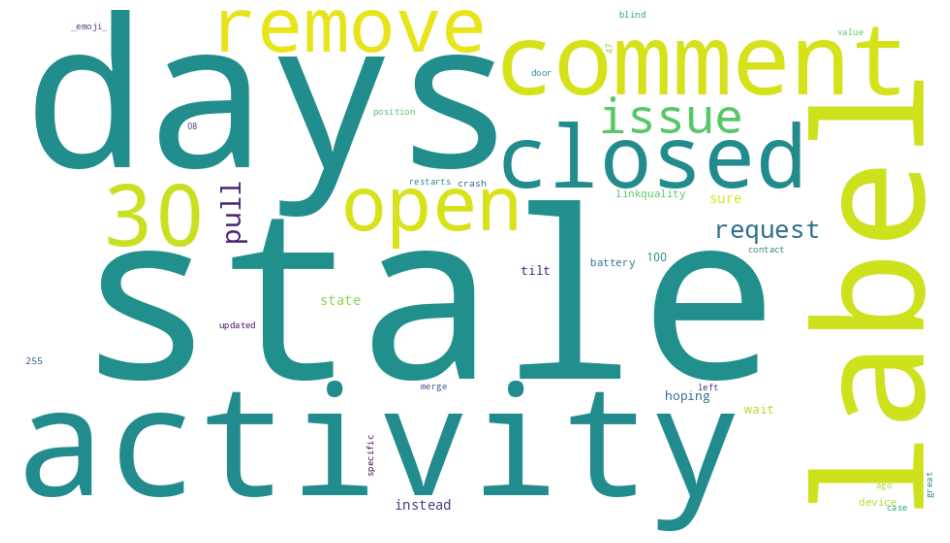

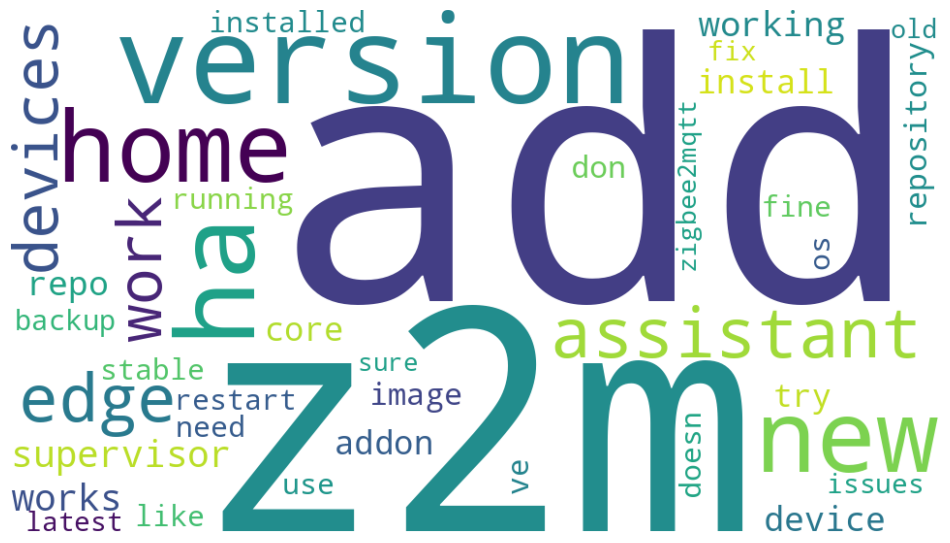

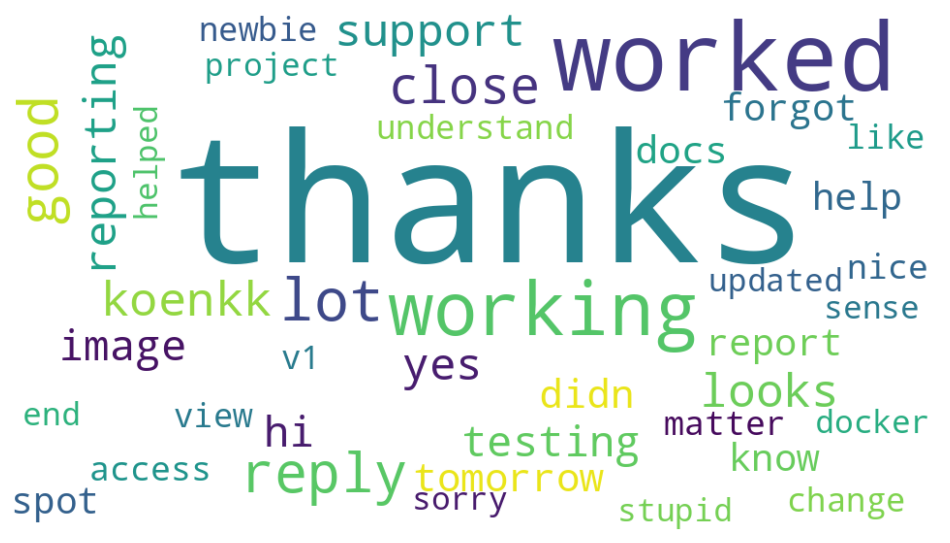

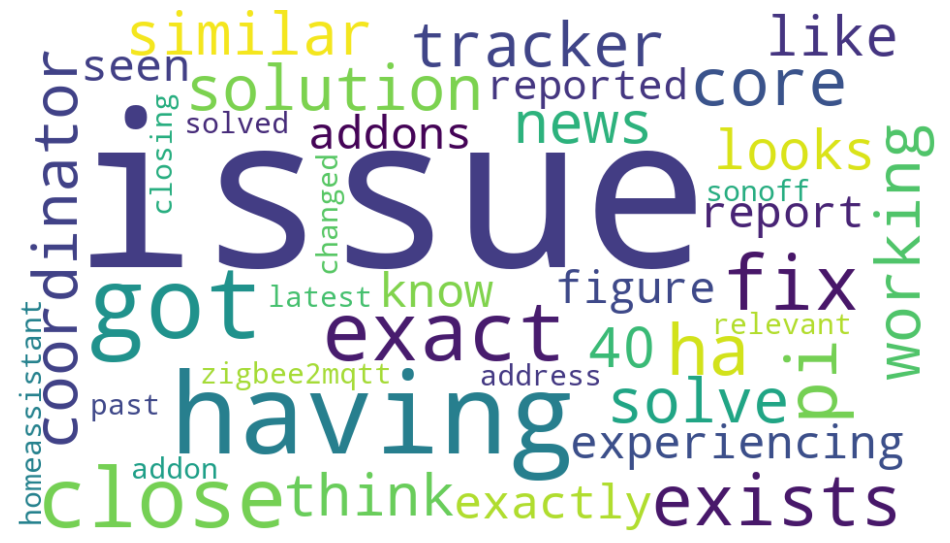

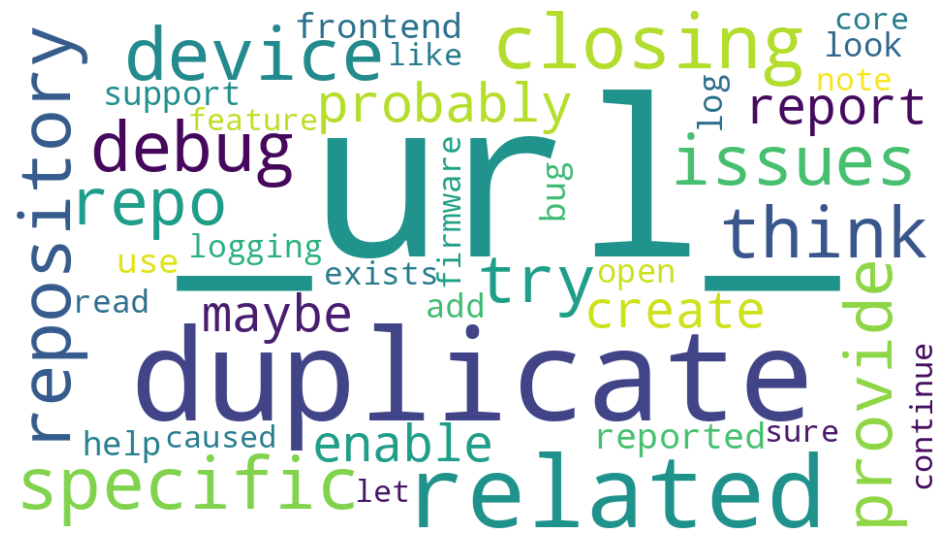

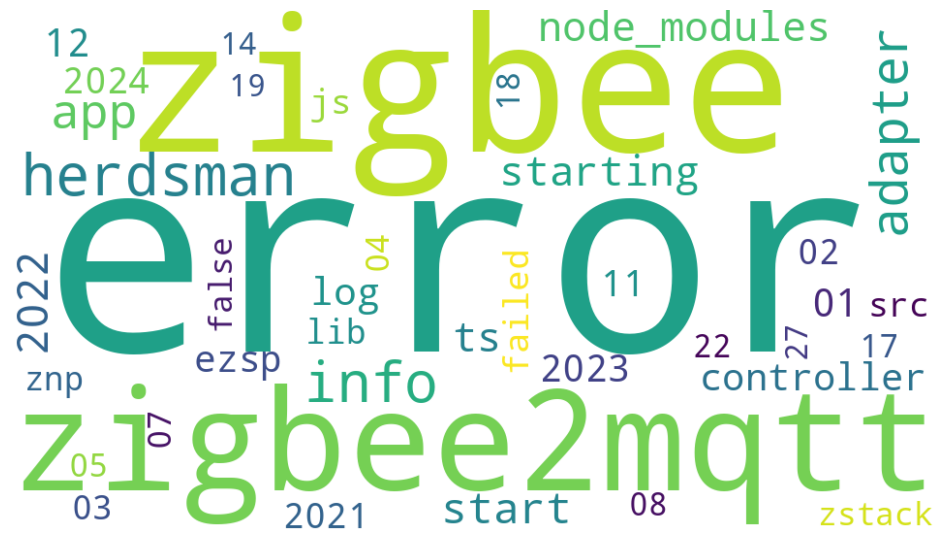

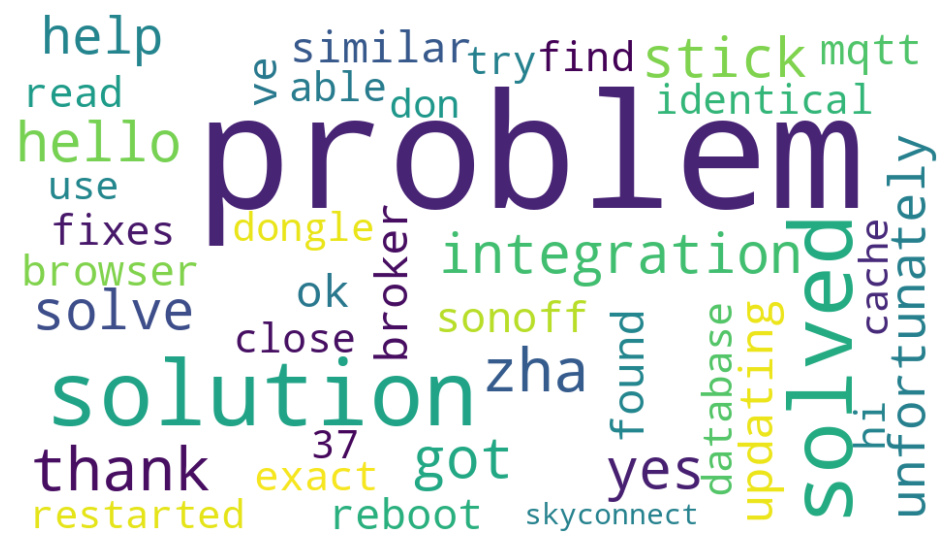

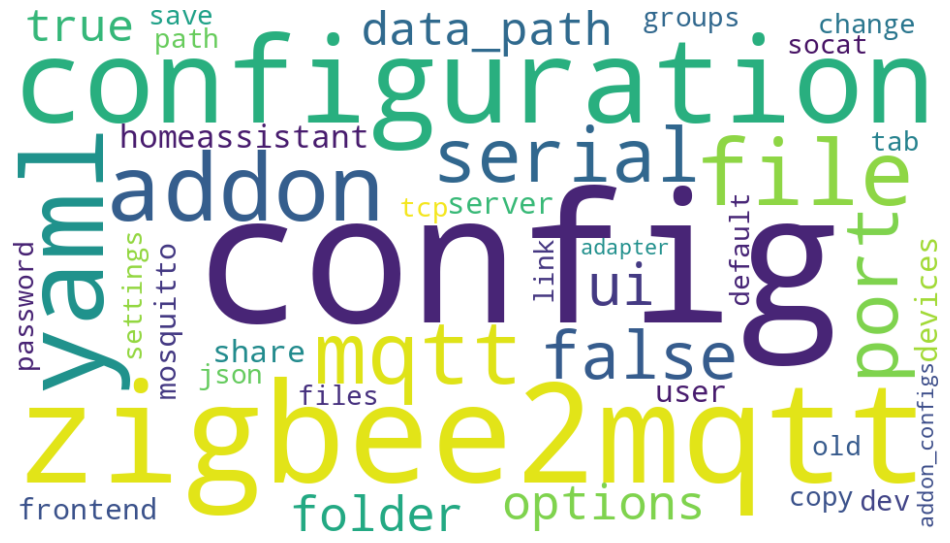

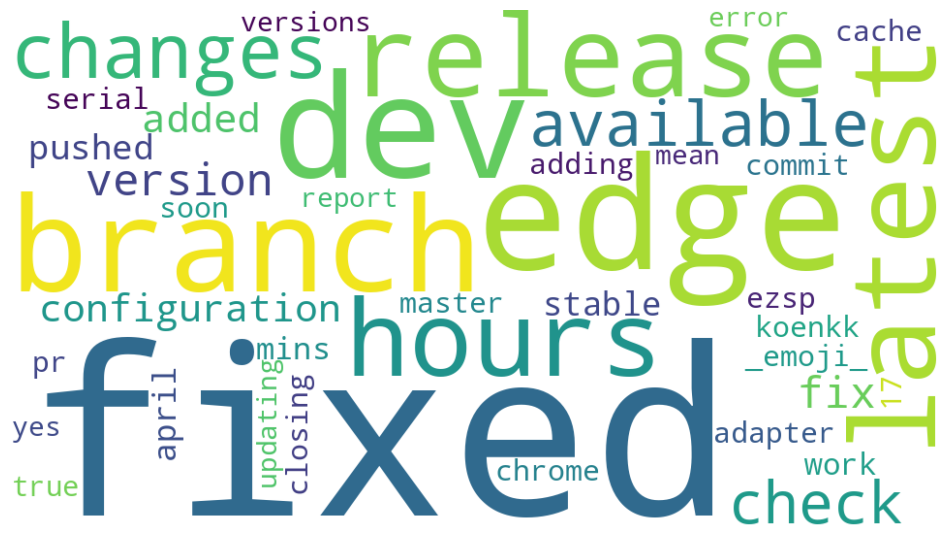

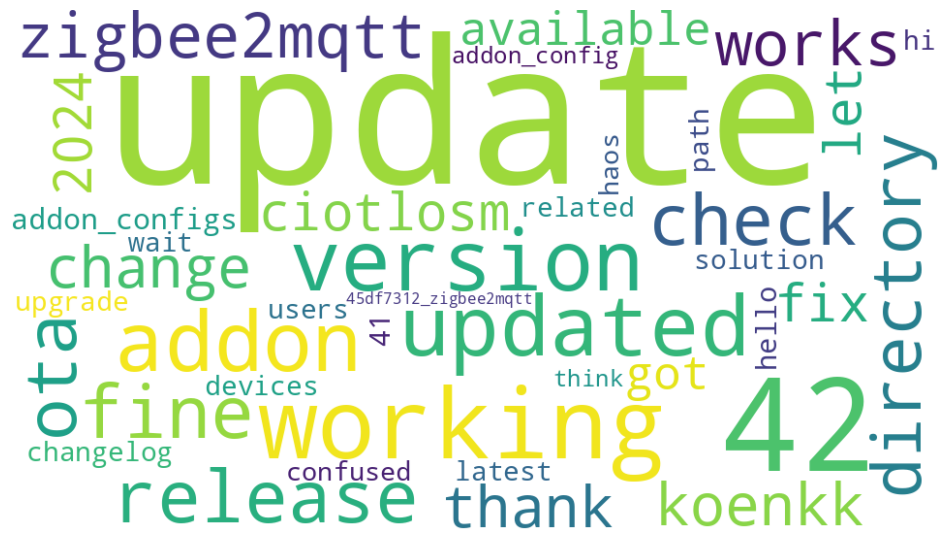

In [21]:
wordcloud_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())

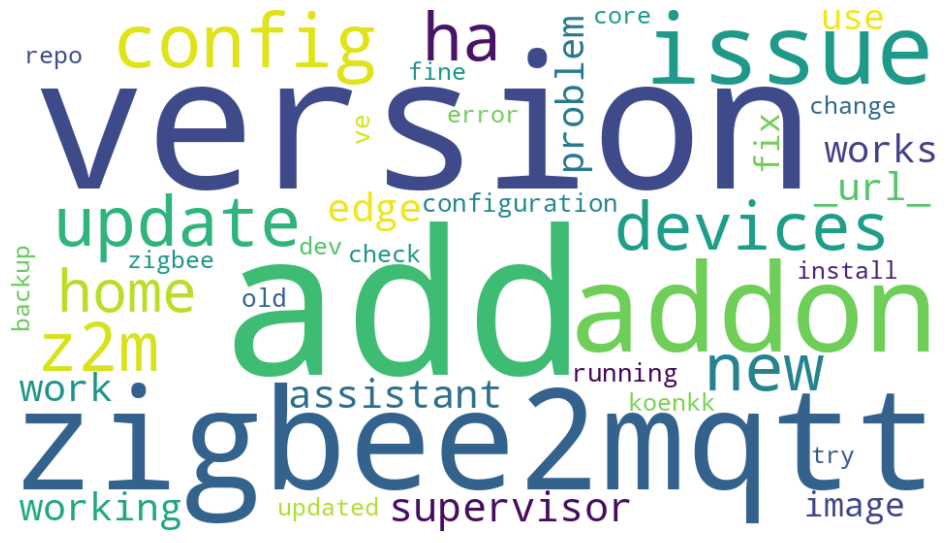

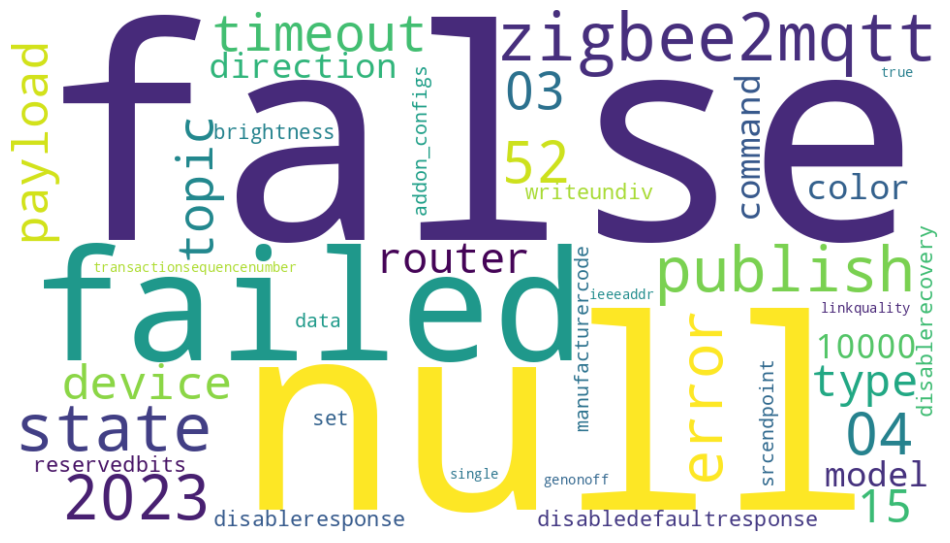

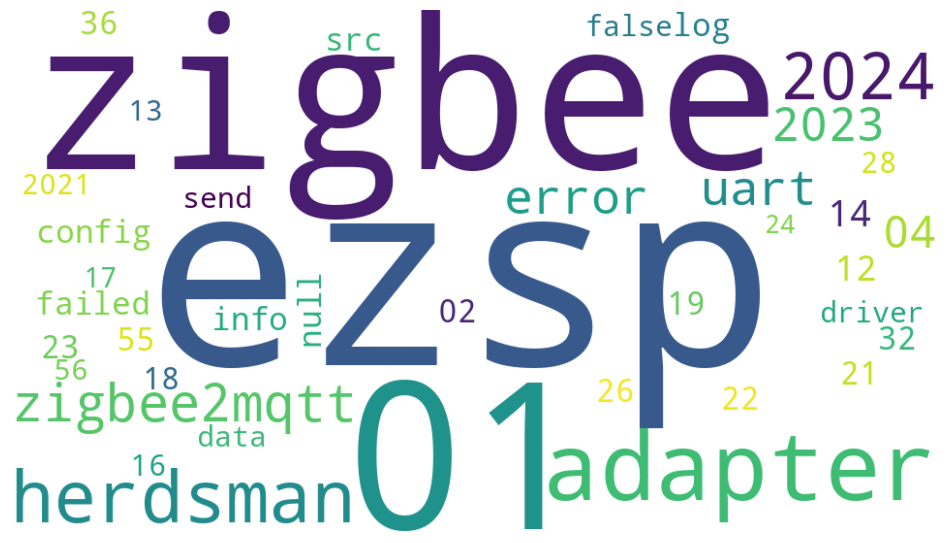

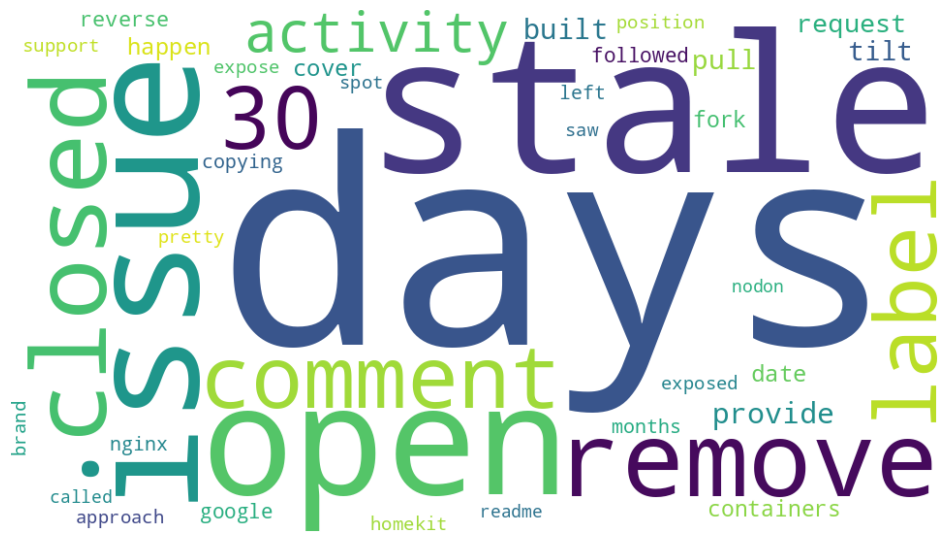

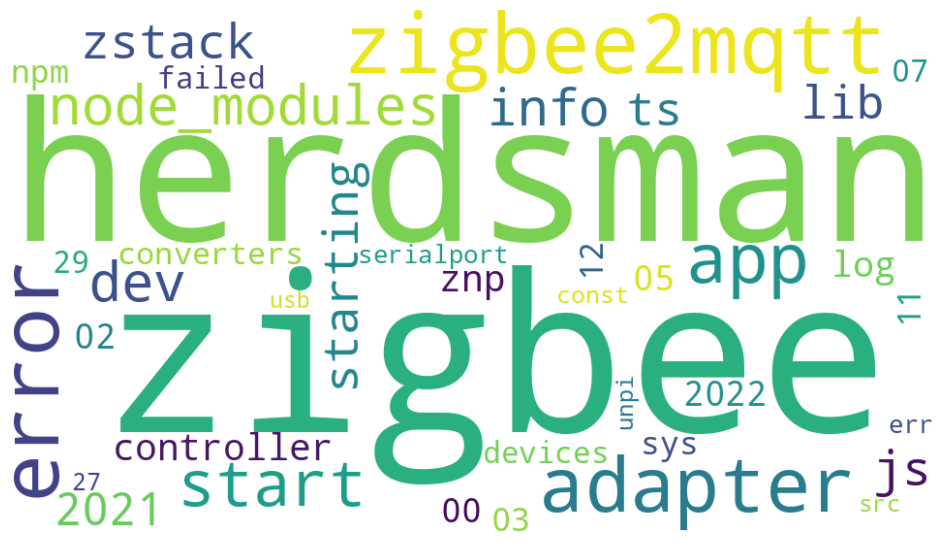

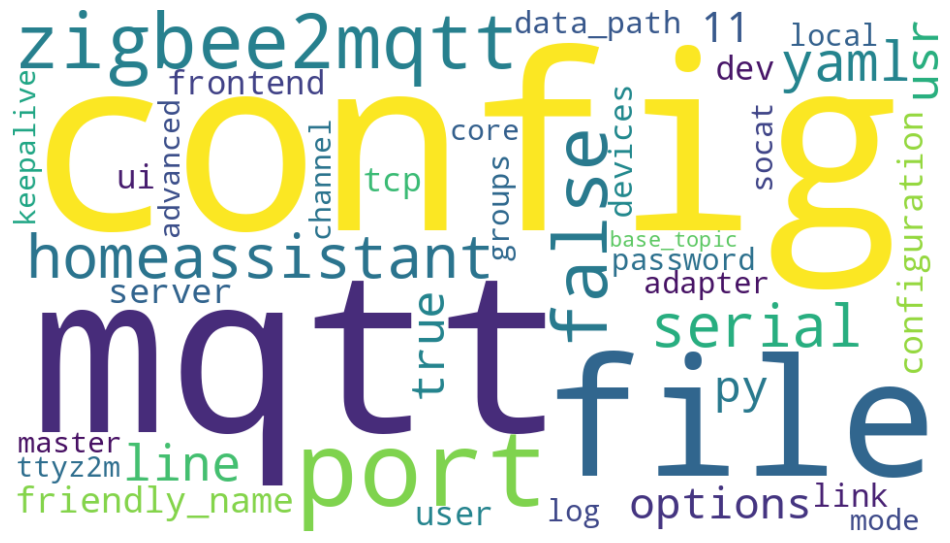

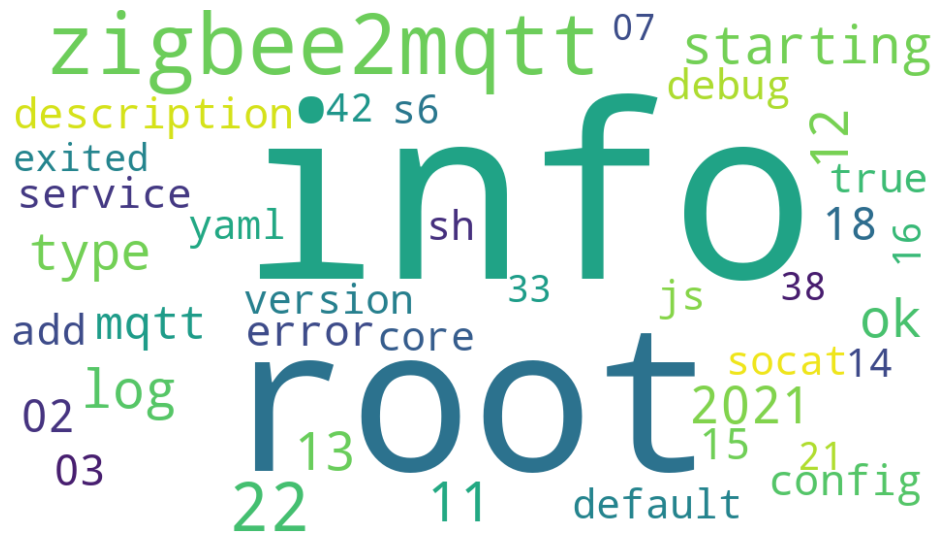

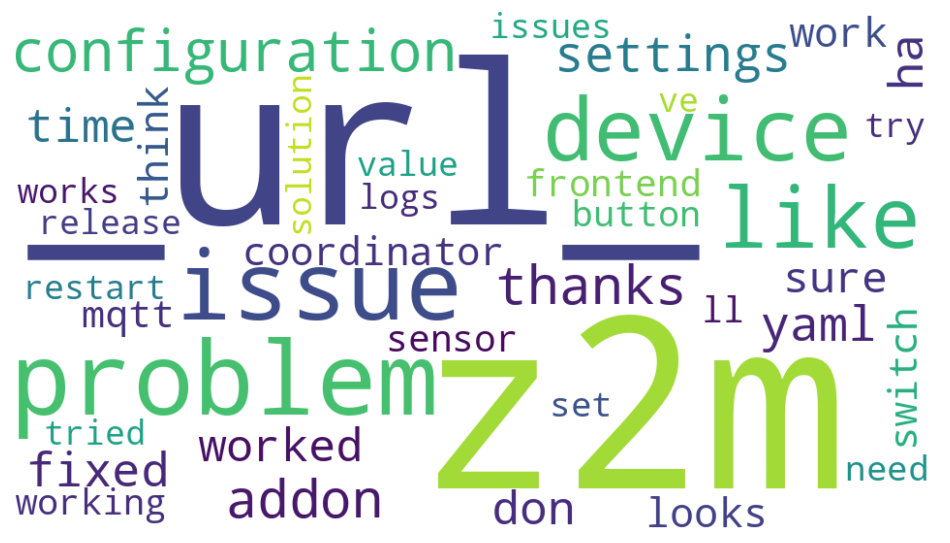

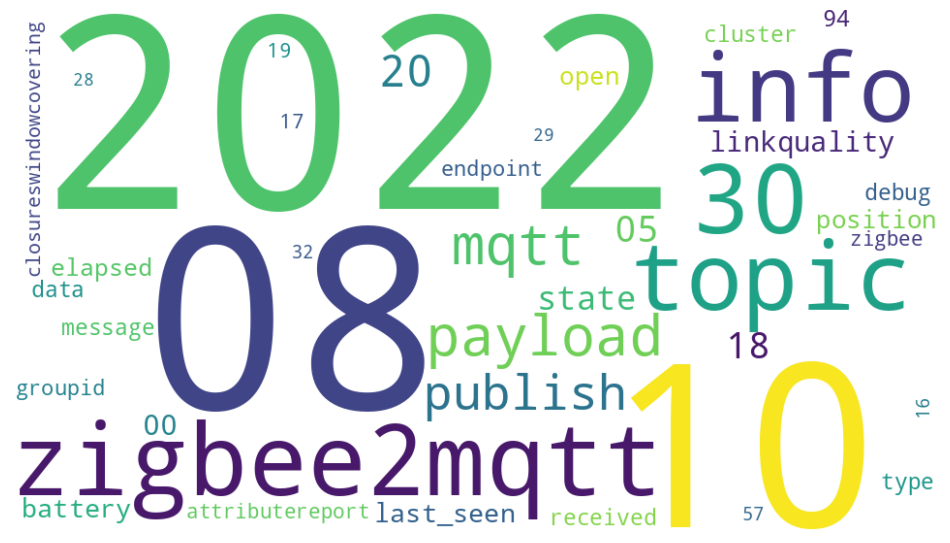

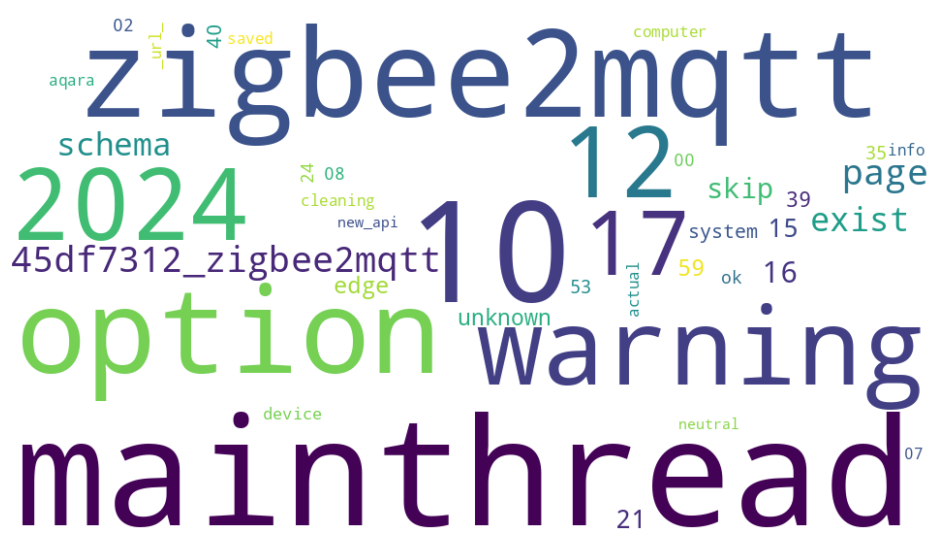

In [22]:
wordcloud_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())

## Modelado de temas utilizando Gensim
Otra herramienta que se puede utilizar para le creación de modelos temáticos es Gensim, ofrece una mayor variedad de algoritmos para los cálculos de modelos en comparación con *scikit-learn* y también puede proporcionar estimaciones sobre la calidad de los mismos.


### Preparación de los datos
En primer lugar se debe preparar el vocabulario. Se debe realizar una tokenización manual porque Gensim no cuenta con uno integrado y la herramienta espera que todas las líneas estén ya tokenizadas.

En este caso, ya están todos los documentos tokenizados como parte de los primeros pasos que se tomaron en la realización del proyecto. Como muestra, se pueden imprimir 5 documentos aleatorios tokenizados de la columna *tokens* del Data Frame:

In [23]:
print(df['tokens'].sample(5))

2236                                                                                                                                                 Closing,this,as,it,should,sit,under,_URL_,if,not,fixed,yet
2000                                                                                                                                                              Still,getting,it,v,1.22.2-1,image,image,image
42      z2m,in,docker,should,check,if,the,addon_config,zigbee2mqtt,is,empty,and,copy,all,the,files,from,the,old,config,zigbee2mqtt,directory,to,the,new,one,After,that,it,could,change,the,path,in,the,confi...
1109                                                                                                                                                                                      #408,might,be,related
896                                                                                                                                                                     

Debido a que en la columna *tokens* del data frame se almacenan los mismos en formato de cadena y gensim espera que estén en formato lista, se van a volver a tokenizar los textos para obtener el diccionario.

In [24]:
#tokenización
gensim_tokens = [[w for w in re.findall(r'\b\w\w+\b' , comment.lower()) if w not in stopwords] 
                           for comment in df["text"]]

In [25]:
from gensim.corpora import Dictionary

dict_gensim_comments = Dictionary(gensim_tokens)

Es recomendable reducir las dimensiones del vocabulario filtrando las palabras que aparecen con demasiada o muy poca frecuencia. Se definirá un mínimo de 5 documentos en los que las palabras deben aparecer pero que no lo hagan en más de un 70% para mantener unas dimensiones contenidas.

In [26]:
dict_gensim_comments.filter_extremes(no_below=5, no_above=0.7)

Se realiza el cálculo de la matriz de bag-of-words.

In [27]:
bow_gensim_comments = [dict_gensim_comments.doc2bow(comment) for comment in gensim_tokens]

Para finalmente realizar la transformación TF-IDF.

In [28]:
from gensim.models import TfidfModel

tfidf_gensim_comments = TfidfModel(bow_gensim_comments)
vectors_gensim_comments = tfidf_gensim_comments[bow_gensim_comments]

La matriz vectors_gensim_comments es la que se usará para las siguientes tareas.

### Factorización de la Matriz No Negativa (NMF)
Se calculará la Matriz No Negativa de forma similar a cómo se hacía con scikit-learn y se observarán los resultados obtenidos para comprobar si son similares a los obtenidos con anterioridad.

In [32]:
from scipy.sparse import csc_matrix
from gensim.models.nmf import Nmf

nmf_gensim_comments = Nmf(vectors_gensim_comments, num_topics=10, id2word=dict_gensim_comments, kappa=0.1, eval_every=5, random_state=42) 

/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/g

Se define una función que muestre por pantalla los resultados obtenidos:

In [33]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [36]:
display_topics_gensim(nmf_gensim_comments)


Topic 00
  issue (0.05)
  config (0.02)
  thanks (0.02)
  fixed (0.02)
  2023 (0.01)

Topic 01
  stale (0.12)
  days (0.11)
  activity (0.06)
  label (0.06)
  comment (0.06)

Topic 02
  thanks (0.05)
  koenkk (0.03)
  com (0.03)
  issues (0.03)
  https (0.03)

Topic 03
  edge (0.02)
  error (0.01)
  info (0.01)
  device (0.01)
  2022 (0.01)

Topic 04
  zigbee2mqtt (0.04)
  github (0.04)
  issues (0.03)
  com (0.03)
  https (0.03)

Topic 05
  stale (0.13)
  days (0.12)
  activity (0.06)
  label (0.06)
  comment (0.06)

Topic 06
  z2m (0.02)
  add (0.02)
  devices (0.02)
  mqtt (0.02)
  try (0.01)

Topic 07
  configuration (0.02)
  yaml (0.02)
  adapter (0.01)
  user (0.01)
  debug (0.01)

Topic 08
  zigbee2mqtt (0.03)
  addon (0.03)
  hassio (0.02)
  issuecomment (0.01)
  system (0.01)

Topic 09
  assistant (0.02)
  home (0.02)
  version (0.02)
  usb (0.02)
  2024 (0.01)


Se observa que los resultados no son idénticos, pero si cuentan con algunas similitudes. Pese a que los porcentajes obtenidos son menores, las palabras asociadas a los temas sí tienen sentido teniendo en cuenta que para el entrenamiento del modelo no se han utilizado necesariamente los mismos comentarios que los utilizados con anterioridad.

Gensim también cuenta con funciones para calcular la puntuación de coherencia de los *topics*, que puede ser un medidor de calidad del modelo.

In [35]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_comms_coherence = CoherenceModel(model=nmf_gensim_comments, texts=gensim_tokens, dictionary=dict_gensim_comments, coherence='c_v')
nmf_gensim_comms_coherence_score = nmf_gensim_comms_coherence.get_coherence()

print(nmf_gensim_comms_coherence_score)

0.4488647325778645


Se obtiene una puntuación de casi el 45%, lo que indica un modelo de no muy buena calidad. 

Siempre se pueden variar los valores con los que se entrena el modelo para lograr un mejor rendimeinto, algo que es altamente recomendable y se hará a continuación.

In [48]:
#Reducción de dimensiones del vocabulario
dict_gensim_comments.filter_extremes(no_below=3, no_above=0.7)

#Cálculo de la matriz bag-of-words
bow_gensim_comments = [dict_gensim_comments.doc2bow(comment) for comment in gensim_tokens]

#Transformación TF-IDF
tfidf_gensim_comments = TfidfModel(bow_gensim_comments)
vectors_gensim_comments = tfidf_gensim_comments[bow_gensim_comments]

In [49]:
#NMF
nmf_gensim_comments = Nmf(vectors_gensim_comments, num_topics=10, id2word=dict_gensim_comments, kappa=0.5, eval_every=10, random_state=42)

#Resultados
display_topics_gensim(nmf_gensim_comments)

/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:578: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:607: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/gensim/models/nmf.py:620: DeprecationWarning: Please import `csc_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csc` namespace is deprecated and will be removed in SciPy 2.0.0.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
/home/diego/.pyenv/versions/gvtiaenv/lib/python3.10/site-packages/g


Topic 00
  issue (0.05)
  add (0.02)
  error (0.02)
  zigbee2mqtt (0.01)
  supervisor (0.01)

Topic 01
  stale (0.10)
  days (0.10)
  activity (0.05)
  label (0.05)
  comment (0.05)

Topic 02
  info (0.01)
  add (0.01)
  edge (0.01)
  repository (0.01)
  don (0.01)

Topic 03
  config (0.02)
  issues (0.02)
  file (0.02)
  zigbee2mqtt (0.02)
  addon (0.02)

Topic 04
  images (0.03)
  githubusercontent (0.03)
  user (0.03)
  png (0.03)
  image (0.02)

Topic 05
  stale (0.10)
  days (0.09)
  activity (0.05)
  30 (0.05)
  label (0.05)

Topic 06
  koenkk (0.05)
  issues (0.05)
  github (0.05)
  com (0.04)
  update (0.03)

Topic 07
  thanks (0.10)
  devices (0.02)
  work (0.02)
  works (0.01)
  edge (0.01)

Topic 08
  zigbee (0.02)
  adapter (0.02)
  herdsman (0.01)
  ok (0.01)
  home (0.01)

Topic 09
  app (0.02)
  false (0.02)
  error (0.01)
  zigbee2mqtt (0.01)
  js (0.01)


In [50]:
#Coherencia y calidad del modelo
nmf_gensim_comms_coherence = CoherenceModel(model=nmf_gensim_comments, texts=gensim_tokens, dictionary=dict_gensim_comments, coherence='c_v')
nmf_gensim_comms_coherence_score = nmf_gensim_comms_coherence.get_coherence()

print(nmf_gensim_comms_coherence_score)

0.4421227206164574


Tras realizar pruebas con distintos valores, no se ha conseguido elevar la puntuación, pero si se aprecian diferencias respecto a las palabras que componen cada uno de los temas.

### LDA
El modelado *LDA* junto con *Gensim* es muy sencillo de realizar, sobre todo si los datos ya están preparados como es el caso.

Se utiliza la clase *LdaModel* junto con una gran variedad de parámetros para la creación del modelo. Por ahora se utilizarán los valores recomendados para los parámetros.

In [59]:
from gensim.models import LdaModel

lda_gensim_comms = LdaModel(corpus=bow_gensim_comments, id2word=dict_gensim_comments, chunksize=2000,
    alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [61]:
display_topics_gensim(lda_gensim_comms)


Topic 00
  2021 (0.15)
  zigbee2mqtt (0.05)
  https (0.04)
  com (0.03)
  debug (0.03)

Topic 01
  dev (0.09)
  type (0.06)
  devices (0.06)
  true (0.04)
  description (0.03)

Topic 02
  false (0.07)
  null (0.05)
  failed (0.05)
  error (0.05)
  npm (0.04)

Topic 03
  add (0.03)
  z2m (0.02)
  version (0.02)
  zigbee2mqtt (0.02)
  issue (0.02)

Topic 04
  zigbee2mqtt (0.06)
  08 (0.06)
  2022 (0.06)
  info (0.06)
  mqtt (0.05)

Topic 05
  zigbee (0.05)
  herdsman (0.05)
  adapter (0.04)
  zigbee2mqtt (0.03)
  error (0.03)

Topic 06
  config (0.05)
  zigbee2mqtt (0.04)
  converters (0.02)
  addon (0.02)
  zigbee (0.02)

Topic 07
  zigbee2mqtt (0.04)
  supervisor (0.04)
  info (0.03)
  22 (0.03)
  root (0.03)

Topic 08
  github (0.07)
  days (0.07)
  com (0.07)
  https (0.06)
  issue (0.06)

Topic 09
  config (0.06)
  zigbee2mqtt (0.03)
  port (0.03)
  yaml (0.03)
  ui (0.03)


Resulta más complicado de interpretar los temas obtenidos en esta ocasión en comparación con los calculados por NMF.

Gensim permite calcular el valor de la complejidad, útil para medir cómo de bien un modelo predice una muestra.

In [62]:
lda_gensim_comms.log_perplexity(vectors_gensim_comments)

-7.935529949138582

#### Puntuación de coherencia
Al igual que con el método NMF, también es posible calcular la puntuación de coherencia de un modelo que hace uso de LDA.

La librería ofrece una herramienta que encapsula todos los pasos necesarios para el cálculo:

In [63]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_comms_coherence = CoherenceModel(model=lda_gensim_comms, texts=gensim_tokens, dictionary=dict_gensim_comments, coherence='c_v')
lda_gensim_comms_coherence_score = lda_gensim_comms_coherence.get_coherence()

print(lda_gensim_comms_coherence_score)

0.5089293595408664


Simplemente sustituyendo *lda* por *nmf* se puede calcular la coherencia del modelo NMF y así comparar los resultados.

In [65]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_comms_coherence = CoherenceModel(model=nmf_gensim_comments, texts=gensim_tokens, dictionary=dict_gensim_comments, coherence='c_v')
nmf_gensim_comms_coherence_score = nmf_gensim_comms_coherence.get_coherence()

print(nmf_gensim_comms_coherence_score)

0.4421227206164574


El resultado obtenido con NMF es inferior, indicando que el modelo LDA arroja una mejor aproximación a los temas reales en comparación.

Calcular la coherencia de los temas individualmente con el modelo LDA es aún más sencillo porque esta función se encuentra ya implementada en el propio modelo.

In [66]:
top_topics = lda_gensim_comms.top_topics(vectors_gensim_comments, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)

print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.5743.


Es posible mostrar la coherencia de los temas individualmente junto con las palabras más importantes de cada uno:

In [67]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-0.6547435072151491, 'zigbee herdsman adapter zigbee2mqtt error'),
 (-1.1261347578208276, 'add z2m version zigbee2mqtt issue'),
 (-1.368853447927951, '2021 zigbee2mqtt https com debug'),
 (-1.3848057380849284, 'zigbee2mqtt 08 2022 info mqtt'),
 (-1.4457958850887045, 'github days com https issue'),
 (-1.472352358111992, 'false null failed error npm'),
 (-1.7540103671091178, 'config zigbee2mqtt port yaml ui'),
 (-1.8558557364175818, 'config zigbee2mqtt converters addon zigbee'),
 (-2.220391413962539, 'dev type devices true description'),
 (-2.4601792327888505, 'zigbee2mqtt supervisor info 22 root')]

#### Búsqueda del número óptimo de temas
Es difícil conocer el número correcto de temas que se deben utilizar para un modelo pues supondría una gran cantidad de tiempo variar los valores de los parámetros mediante prueba y error, guardar estos valores junto con los resultados obtenidos y luego comparar manualmente cuál ofrece un mejor desempeño.

Para esta tarea, Gensim ofrece la posibilidad de calcular este valor mediante la clase *LdaMulticore*.

Se debe tener en cuenta que este proceso necesita de un tiempo de ejecución considerablemente mayor en comparación a los otros vistos previamente porque crea tantos modelos como el usuario le indica en el parámetro *range* en el bucle for.En este caso, se han creado 16 modelos (rango 5-21) que ha conllevado un tiempo de ejecución de 7 minutos aproximadamente.

In [51]:
from gensim.models.ldamulticore import LdaMulticore

lda_comms_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(corpus=bow_gensim_comments, id2word=dict_gensim_comments, chunksize=2000,
                             eta='auto', iterations=400, num_topics=n, passes=20, 
                             eval_every=None, random_state=42)
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_tokens, 
                                   dictionary=dict_gensim_comments, coherence='c_v')
    lda_comms_model_n.append((n, lda_model, lda_coherence.get_coherence()))

100%|██████████| 16/16 [07:07<00:00, 26.75s/it]


Es posible generar un **gráfico de coherencia** para evaluar la calidad del modelo LDA en función del número de temas utilizado. Esto permite determinar el número óptimo de temas para LDA, buscando un punto en el que la coherencia sea máxima antes de estabilizarse o incluso reducirse.

En el proceso se crea un DataFrame con los valores almacenados en *lda_comms_model_n* que contiente: 
- **n**: número de temas utilizados por el modelo 
- **model**: modelo LDA correspondiente a cada número de temas 
- **coherence**: valor de coherencia del modelo - indicador de calidad 

Para el DataFrame se establece *n* como índice para facilitar la visualización de cómo varía la coherencia en función de los temas utilizados.

<Axes: xlabel='n'>

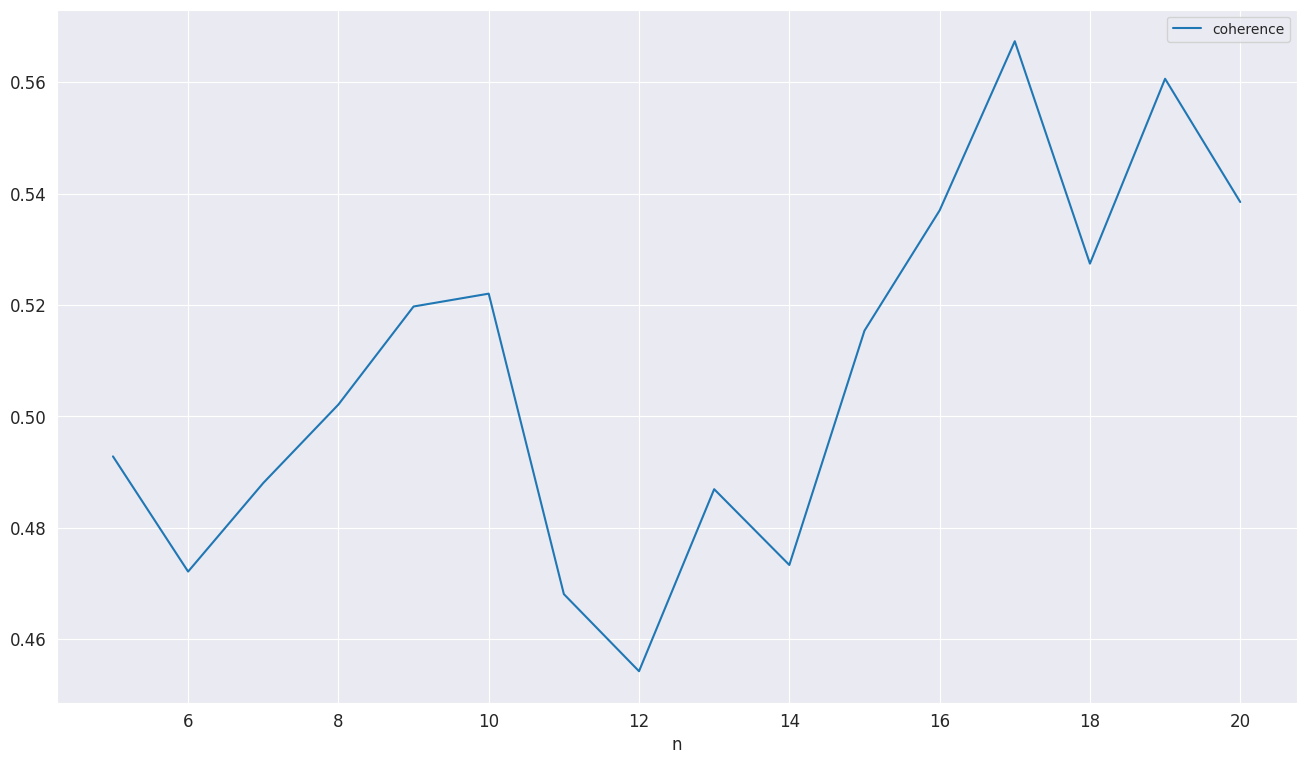

In [52]:
pd.DataFrame(lda_comms_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

A raíz del gráfico generado se observa con claridad que la mayor puntuación de coherencia se ha conseguido utilizando 17 temas obteniendo aproximadamente un 57%, más de un 10% con respecto al obtenido con NMF.

A continuación, se pueden mostrar los resultados de las palabras con mayor peso para cada tema para una comparación con los resultados obtenidos con el resto de modelos:

In [56]:
display_topics_gensim(lda_comms_model_n[12][1])


Topic 00
  https (0.05)
  com (0.04)
  user (0.04)
  images (0.04)
  zigbee2mqtt (0.04)

Topic 01
  2024 (0.08)
  z2m (0.05)
  06 (0.05)
  info (0.04)
  11 (0.03)

Topic 02
  homeassistant (0.04)
  file (0.03)
  zigbee2mqtt (0.03)
  line (0.03)
  py (0.03)

Topic 03
  zigbee (0.04)
  converters (0.03)
  issue (0.03)
  const (0.02)
  js (0.02)

Topic 04
  zigbee2mqtt (0.06)
  info (0.06)
  init (0.04)
  cont (0.03)
  04 (0.03)

Topic 05
  error (0.05)
  zigbee2mqtt (0.04)
  zigbee (0.04)
  01 (0.04)
  herdsman (0.03)

Topic 06
  config (0.04)
  addon (0.03)
  zigbee2mqtt (0.03)
  add (0.02)
  z2m (0.02)

Topic 07
  supervisor (0.06)
  02 (0.05)
  22 (0.04)
  dev (0.03)
  mainthread (0.03)

Topic 08
  04 (0.09)
  2023 (0.08)
  52 (0.06)
  state (0.05)
  zigbee2mqtt (0.04)

Topic 09
  port (0.04)
  config (0.04)
  serial (0.04)
  mqtt (0.03)
  false (0.03)

Topic 10
  days (0.12)
  stale (0.12)
  open (0.07)
  issue (0.06)
  closed (0.06)

Topic 11
  root (0.07)
  ok (0.03)
  info (0.02)

También se pueden generar las nubes de palabras para los temas obtenidos con este modelo:

In [57]:
def wordcloud_topics_gensim(model, no_top_words=40):
    for topic in range(0, model.num_topics):
        size = {}
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

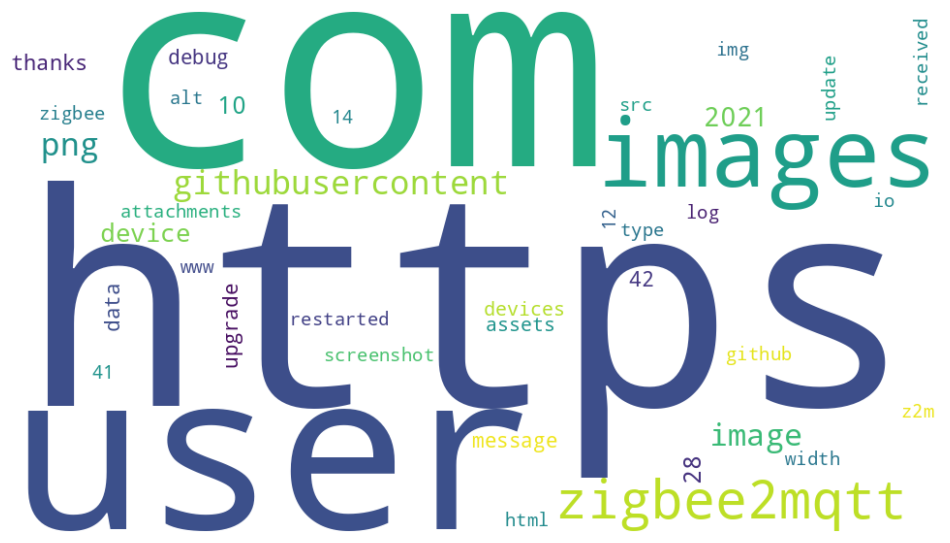

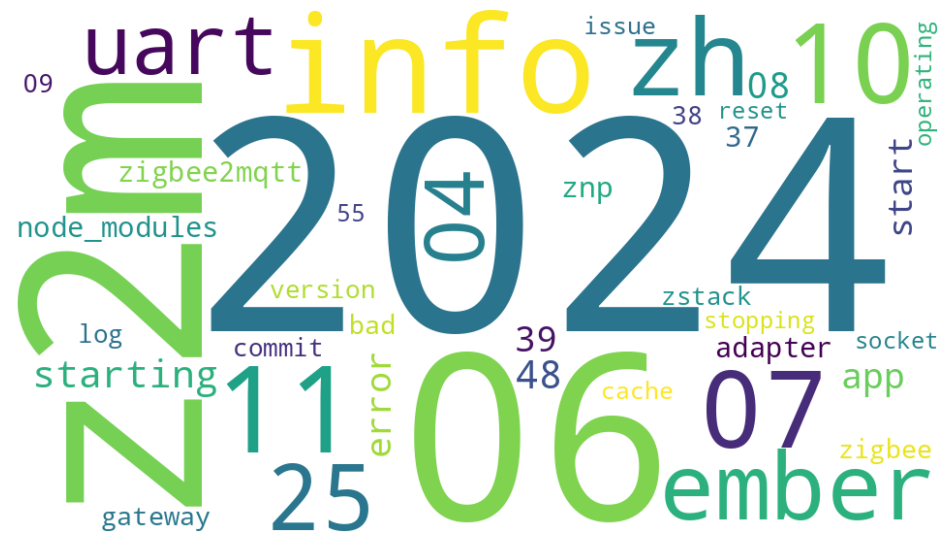

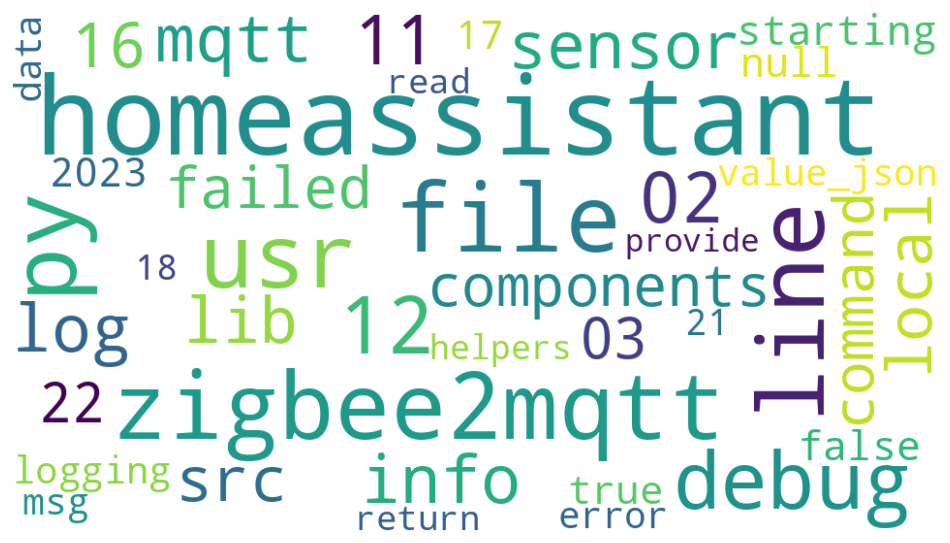

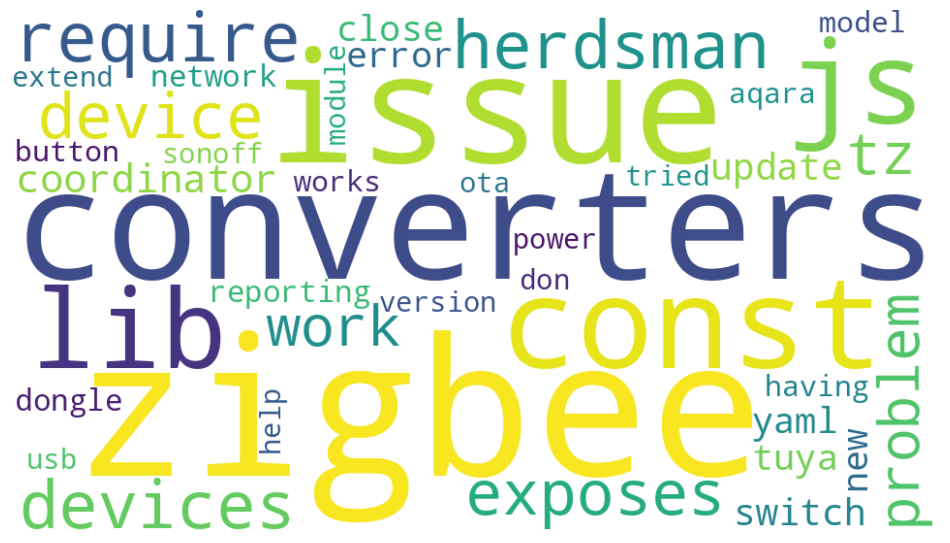

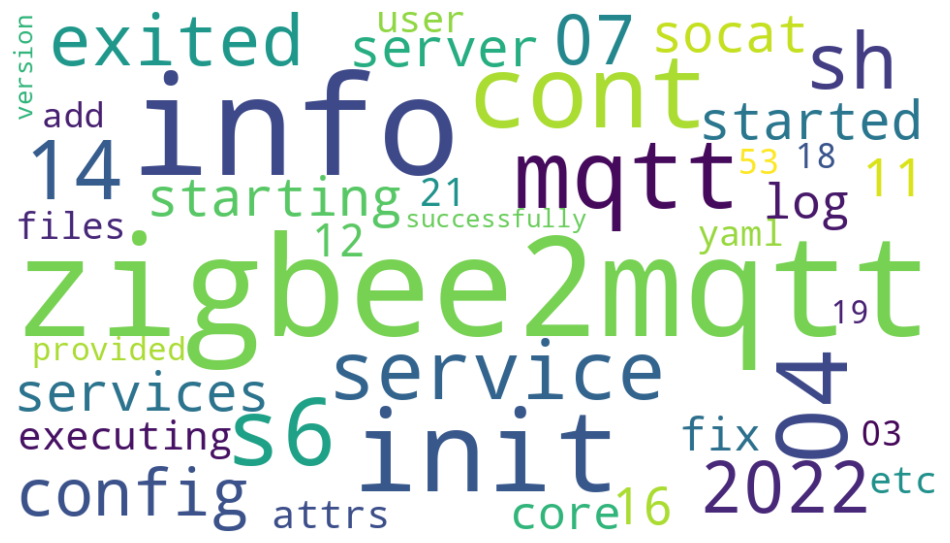

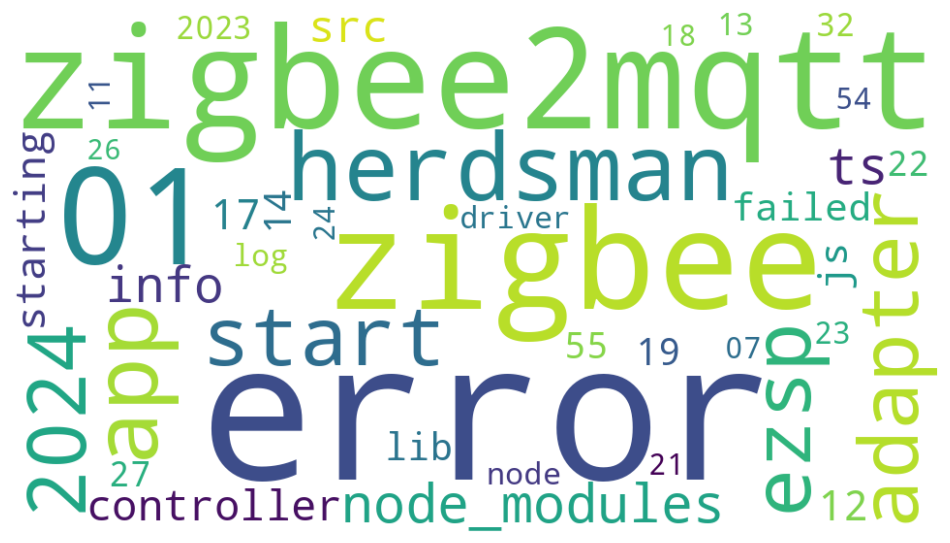

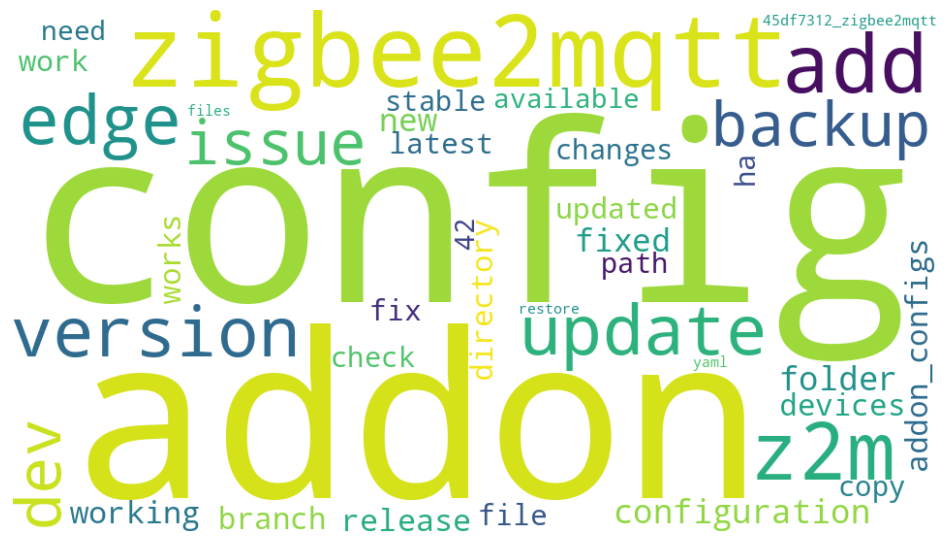

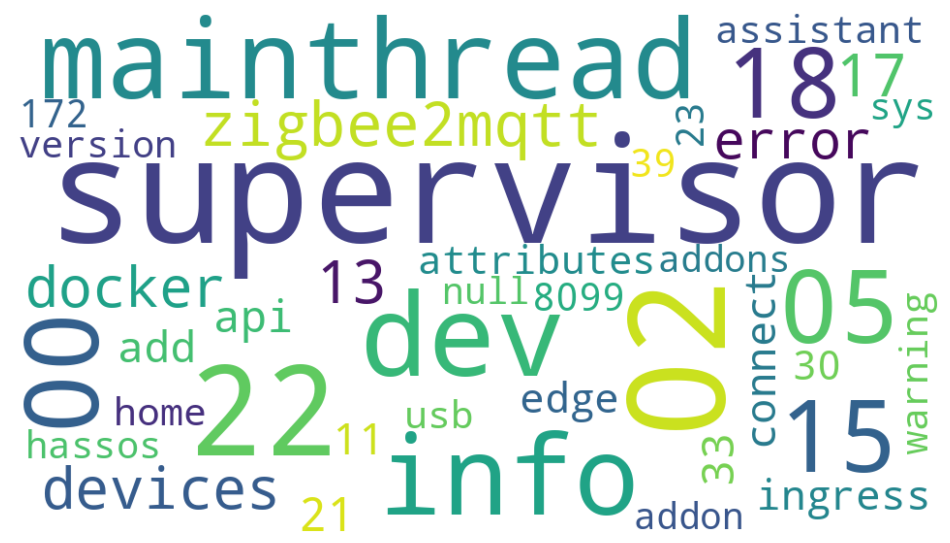

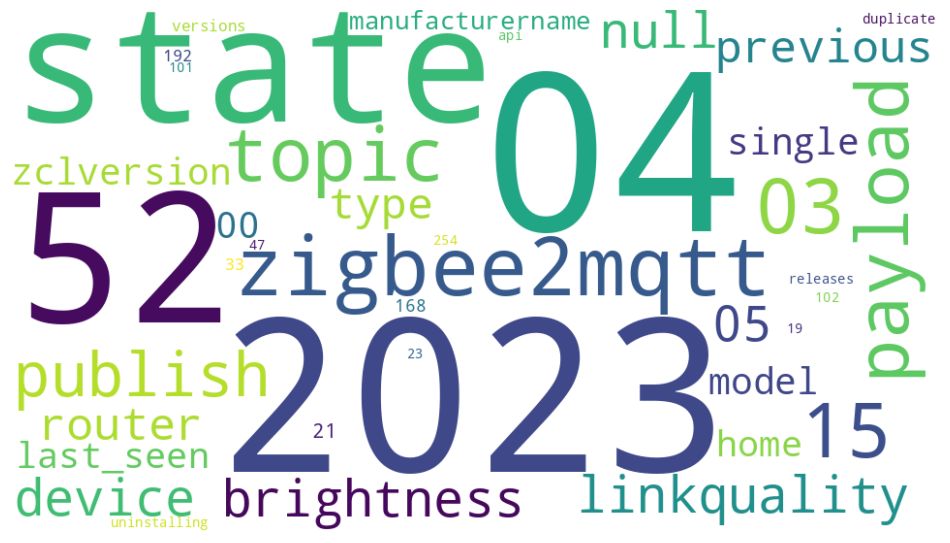

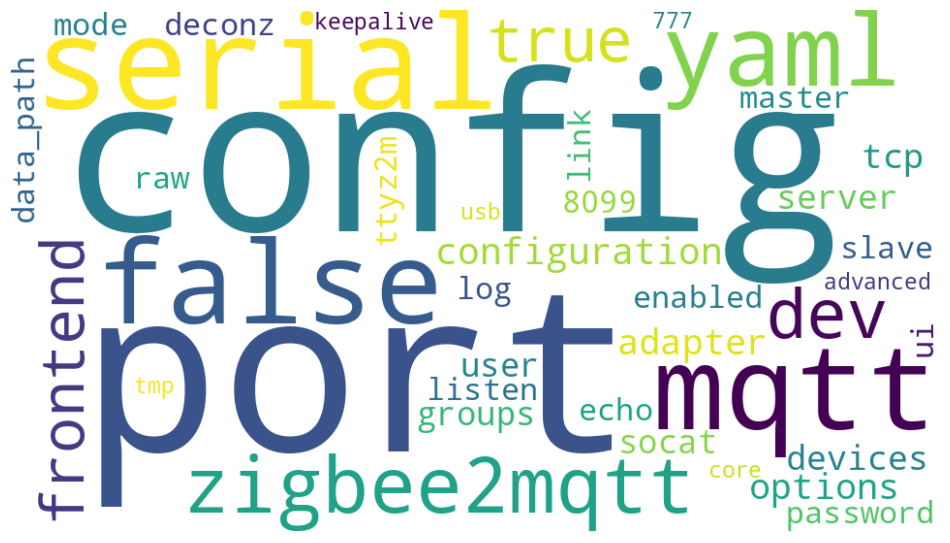

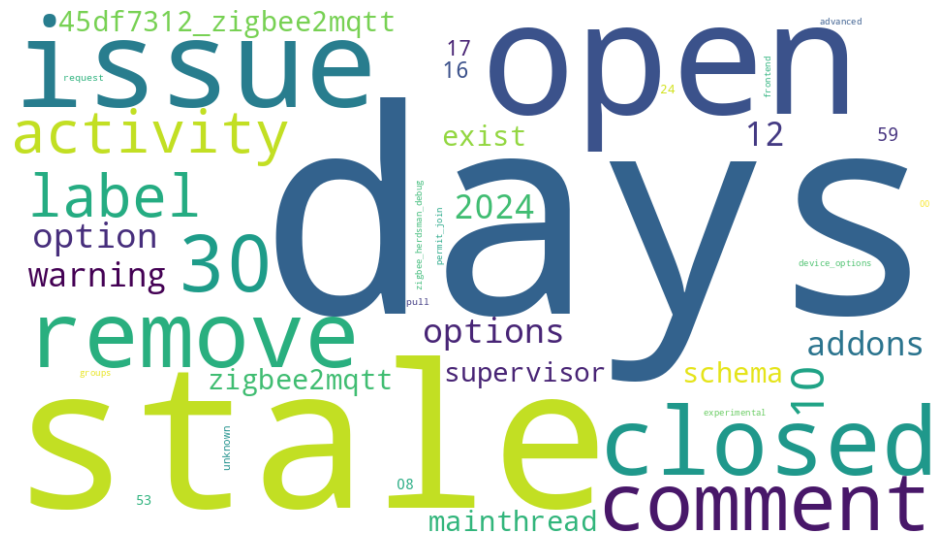

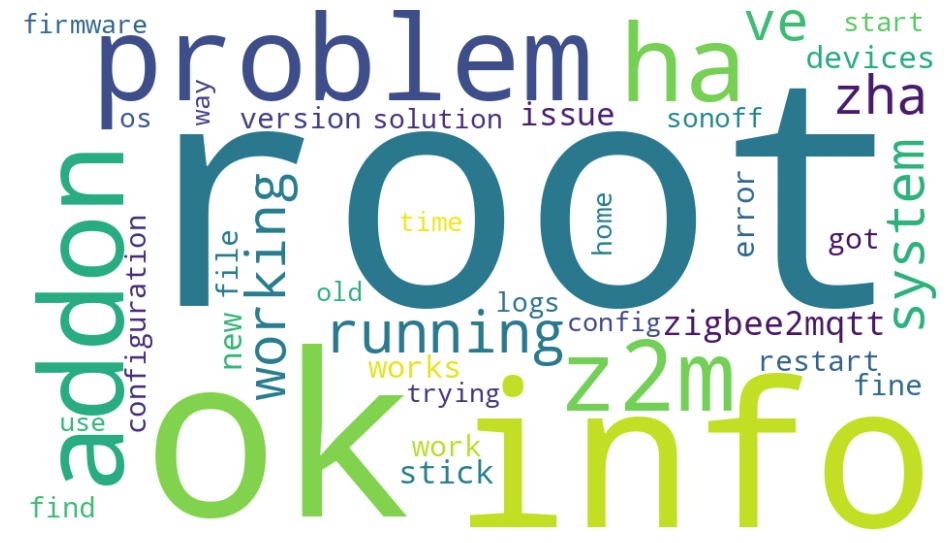

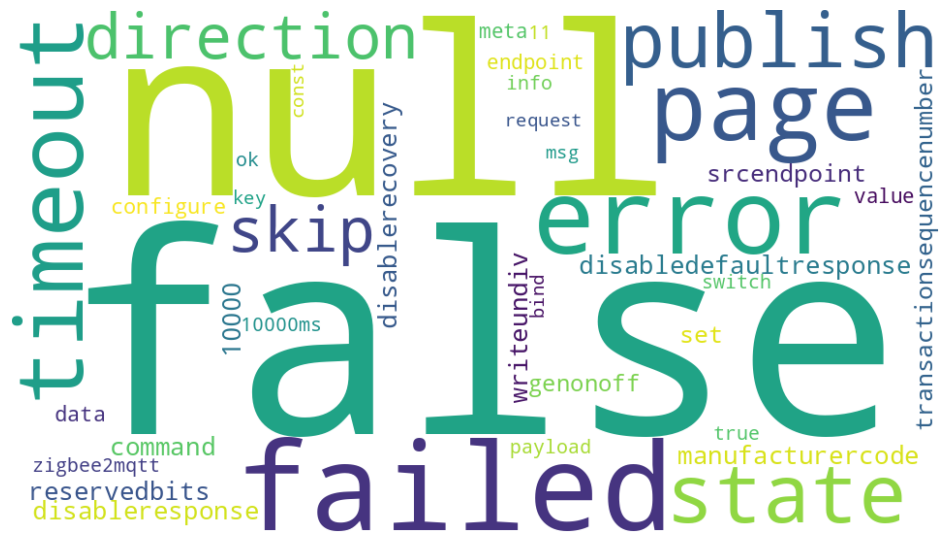

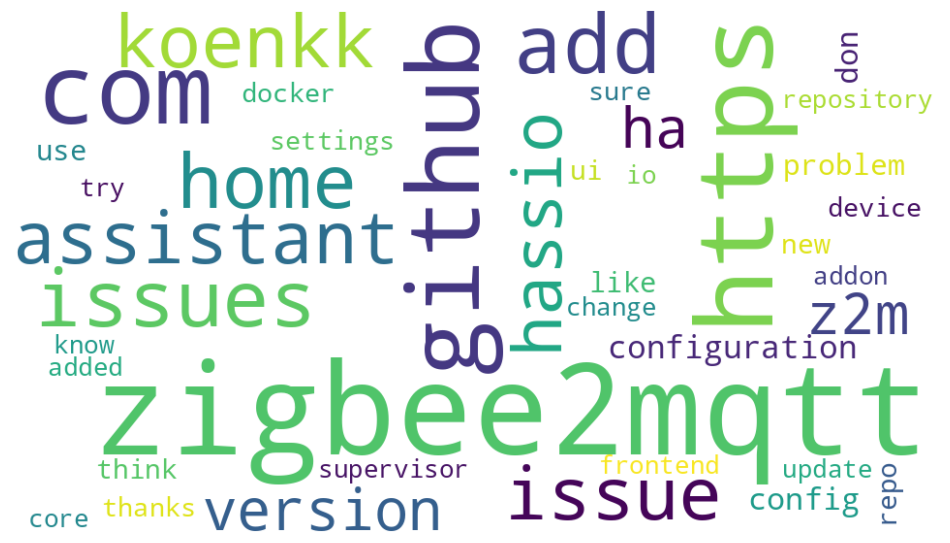

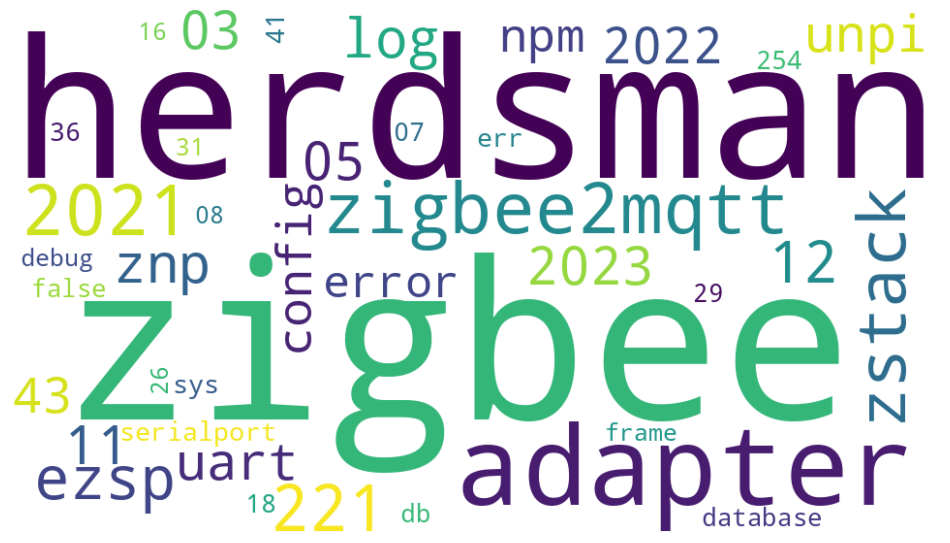

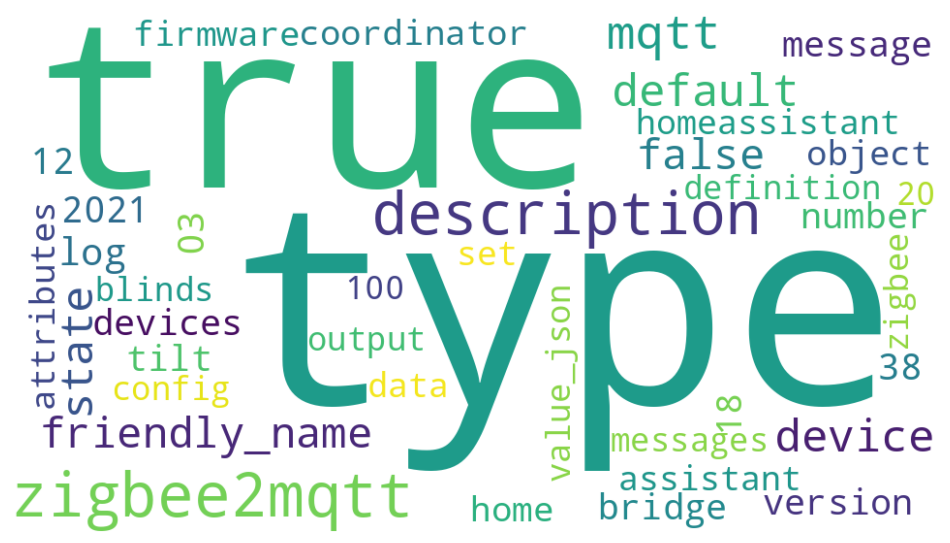

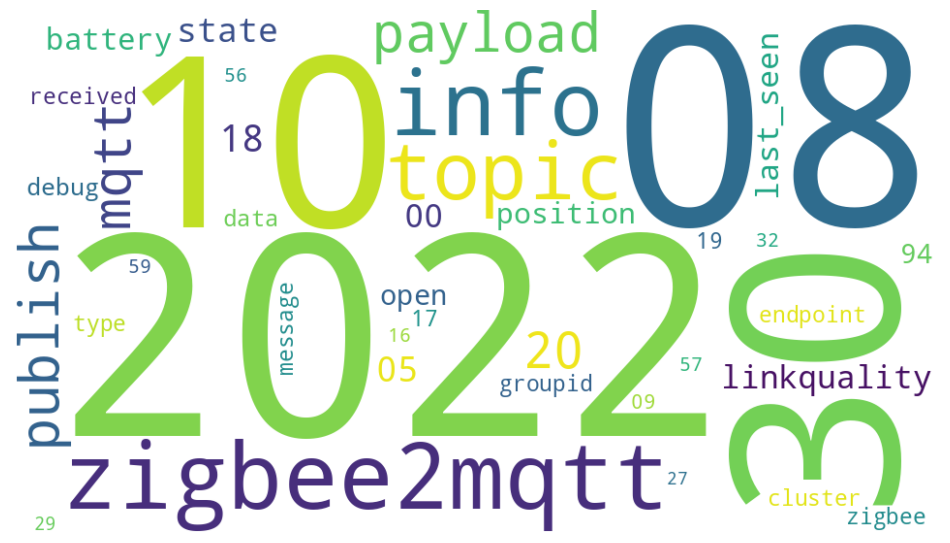

In [58]:
wordcloud_topics_gensim(lda_comms_model_n[12][1])